#### Please set runtime type to GPU: Runtime -> Change runtime type -> GPU

In [ ]:
# first time setup - install dependencies
# !pip install diffusers==0.24.0 accelerate==0.25.0

In [ ]:
# first time setup - download example data and files
# !huggingface-cli download microsoft/mri-autoencoder-v0.1 inference.py metrics.py data_utils.py example_data/mri_complex_images.npz --local-dir .

In [ ]:
import numpy as np
from diffusers.models import AutoencoderKL
from inference import run_inference_two_channels, run_inference_three_channels
from metrics import ssim, psnr
from matplotlib import pyplot as plt


In [3]:
def display_images(input, recon, metrics_dict, type='magnitude'):
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))
    shrink = 1.0
    handle0 = axs[0].imshow(input[0], cmap='gray')
    axs[0].set_title(f"Input Image - {type}")
    plt.colorbar(handle0, ax=axs[0], shrink=shrink)

    handle1 = axs[1].imshow(recon[0], cmap='gray')
    metrics_str = ', '.join([f"{k}:{v:.2f}" for k, v in metrics_dict.items()])
    axs[1].set_title(f"Recon Image - {type} \n {metrics_str}")
    plt.colorbar(handle1, ax=axs[1], shrink=shrink)

    diff_img = np.abs(input[0] - recon[0])
    handle2 = axs[2].imshow(diff_img, cmap='gray')
    axs[2].set_title(f"Diff Image - {type}")
    plt.colorbar(handle2, ax=axs[2], shrink=shrink)


In [4]:
coil_complex_image = np.load('example_data/mri_complex_images.npz')['knee']
# for brain
# coil_complex_image = np.load('example_data/mri_complex_images.npz')['brain']

config.json: 100%|██████████| 542/542 [00:00<00:00, 2.09MB/s]
diffusion_pytorch_model.safetensors: 100%|██████████| 221M/221M [00:01<00:00, 214MB/s]  


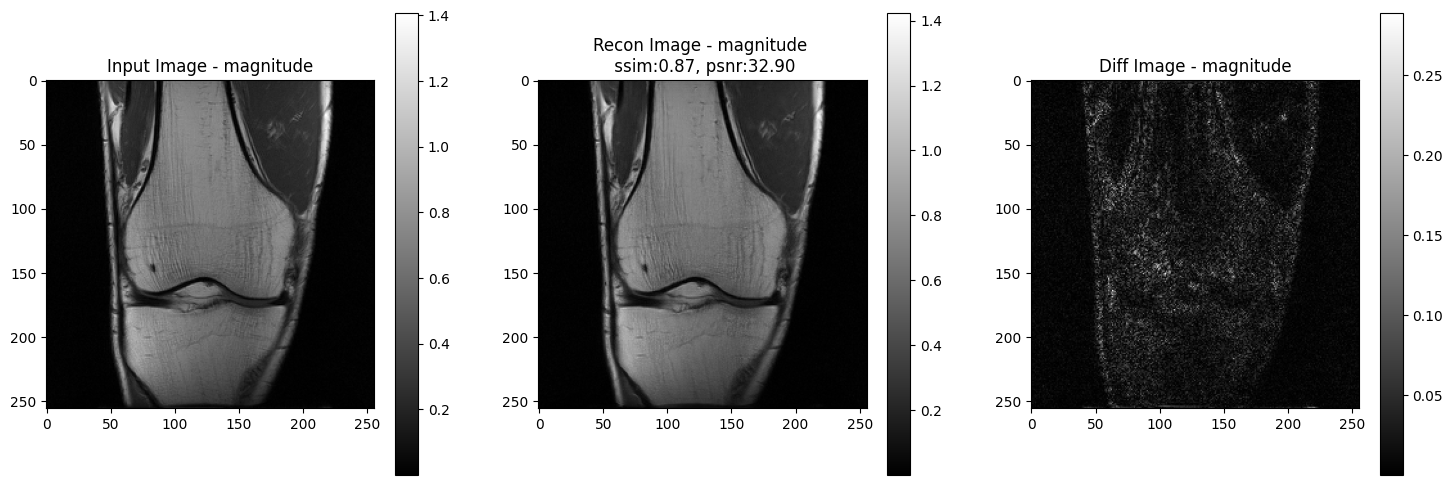

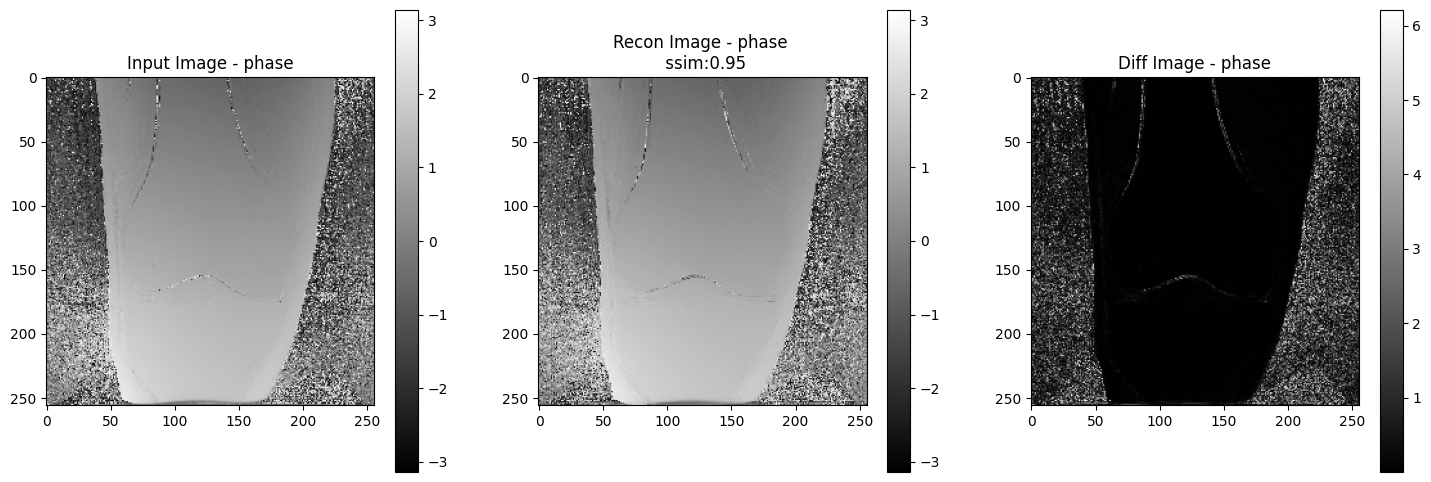

In [5]:
model_path = "microsoft/mri-autoencoder-v0.1"
autoencoder = AutoencoderKL.from_pretrained(model_path)
input, recon = run_inference_two_channels(coil_complex_image, autoencoder, device="cuda")
recon_mag, recon_phase = np.abs(recon), np.angle(recon)
input_mag, input_phase = np.abs(input).astype(np.float32), np.angle(input).astype(np.float32)
ssim_score_mag = ssim(input_mag, recon_mag, data_range=input_mag.max()-input_mag.min())
psnr_score = psnr(input_mag, recon_mag, data_range=input_mag.max()-input_mag.min())
# mask to remove background pixels from ssim calculation in phase image
mask = input_mag > 0.05
masked_input_phase = input_phase * mask
ssim_score_phase = ssim(masked_input_phase, recon_phase * mask, data_range=masked_input_phase.max()-masked_input_phase.min())
display_images(input_mag, recon_mag, {"ssim":ssim_score_mag[0], "psnr":psnr_score})
display_images(input_phase, recon_phase, {"ssim":ssim_score_phase[0]}, type='phase')

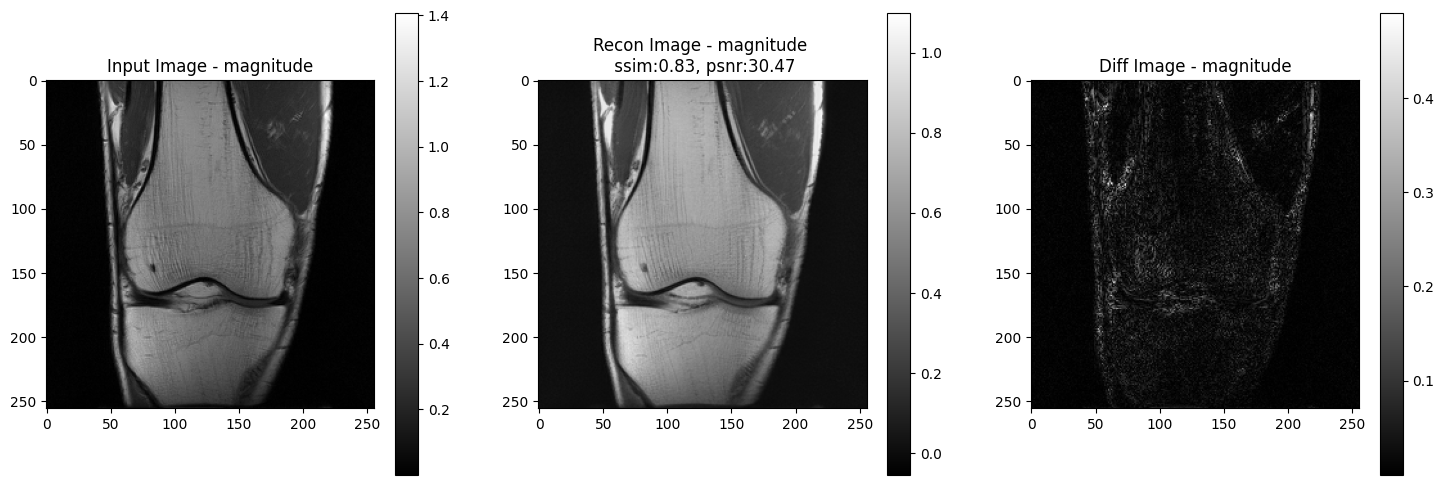

In [6]:
autoencoder = AutoencoderKL.from_pretrained("stabilityai/sdxl-vae")
input, recon = run_inference_three_channels(coil_complex_image, autoencoder, device="cuda")
ssim_score = ssim(input, recon, data_range=input.max()-input.min())
psnr_score = psnr(input, recon, data_range=input.max()-input.min())
display_images(input, recon, {"ssim":ssim_score[0], "psnr":psnr_score})